In [1]:
!make -C .. scenario_config scenario_endpoints scenario_metrics

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'scenario_config'.
make: Nothing to be done for 'scenario_endpoints'.
make: Nothing to be done for 'scenario_metrics'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [3]:
scenario_config_filepath = '../data/processed/scenario-config.nc'
scenario_endpoints_filepath = '../data/processed/scenario-endpoints.nc'
scenario_metrics_filepath = '../data/processed/scenario-metrics.csv'

In [4]:
metrics = [
    'proportion_of_landscape', 'area_mn', 'shape_index_mn', 'edge_density'
]
metric_label_dict = {
    'proportion_of_landscape': 'PLAND',
    'area_mn': 'AREA_MN',
    'shape_index_mn': 'SHAPE_MN',
    'edge_density': 'ED'
}

In [5]:
scenario_config_ds = xr.open_dataset(scenario_config_filepath)
scenario_endpoints_ds = xr.open_dataset(scenario_endpoints_filepath)

scenario_metrics_df = pd.read_csv(scenario_metrics_filepath).rename(
    columns=metric_label_dict)

In [6]:
def df_from_scenario_ds(scenario_ds):
    return scenario_ds['T'].mean(dim=['x', 'y']).to_dataframe().reset_index()

In [7]:
scenario_T_df = df_from_scenario_ds(scenario_config_ds)
# get a scenario temperature data frame from the scenario dataset

# get a scenario temperature data frame from the scenario endpoints dataset
scenario_T_endpoints_df = df_from_scenario_ds(scenario_endpoints_ds)
# repeat the endpoint metrics accross `interactions` and `scenario_runs`
# to have a consistent data frame structure with `scenario_df`
interactions = scenario_config_ds['interaction'].values
scenario_runs = scenario_config_ds['scenario_run'].values
num_interactions = len(interactions)
num_scenario_runs = len(scenario_runs)
scenario_T_endpoints_df = pd.concat(
    [scenario_T_endpoints_df] * num_interactions * num_scenario_runs,
    ignore_index=True).sort_values('change_prop')
scenario_T_endpoints_df['interaction'] = np.tile(
    interactions,
    len(scenario_T_endpoints_df) // num_interactions)
scenario_T_endpoints_df['scenario_run'] = np.tile(
    scenario_runs,
    len(scenario_T_endpoints_df) // num_scenario_runs)

# put it all together in a single data frame
scenario_T_df = pd.concat([scenario_T_df, scenario_T_endpoints_df],
                          ignore_index=True).sort_values('change_prop')

In [8]:
# merge the dataframes of scenario metrics and temperatures
scenario_df = pd.merge(scenario_metrics_df, scenario_T_df)

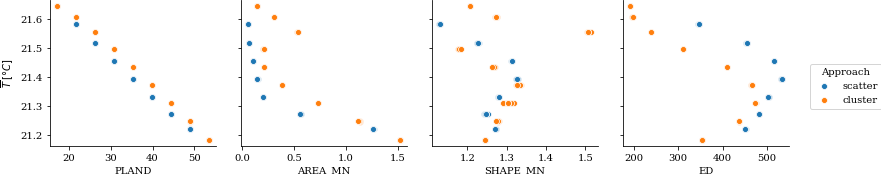

In [9]:
g = sns.pairplot(scenario_df,
                 x_vars=metric_label_dict.values(),
                 y_vars=['T'],
                 hue='interaction')
g.axes.flat[0].set_ylabel('$\\overline{T} \; [\degree C]$')
g._legend.remove()
g.add_legend(title='Approach', bbox_to_anchor=(1.02, .5), frameon=True)
g.fig.savefig('../reports/figures/scenarios-config.pdf', pad_inches=0.02)